In [2]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
import matplotlib.pyplot as plt


In [3]:
dir_name='reparse'
seq_len=15
step=15
cv_split_name='cv_splits_10'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
doc_indices
test_doc_num=8
seed=42

In [4]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
ens_crf_db_name   = 'ensemble_crf_cv_db_all'
ens_lg_db_name = 'ensemble_lg_cv_db_all'
cv_crf_bert_name = 'cv_crf_bert_all'
per_par=True
seq_len=3
step=3

### Open BERT predictions

In [5]:
i=0
splits_bert={}
for i in range(10):
    json_name="split_{}_bert_valid_dict".format(i)
    splits_bert[i]=common_utils.load_json(dir_name,json_name)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_0_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_1_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_2_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_3_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_4_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_5_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_6_bert_valid_dict.json
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_7_bert_valid_dict.json
Opened /scratch/sim_reg6

In [11]:
data=splits_bert[i]['valid_loss']

In [26]:
for k,v in splits_bert.items():
    print(k,v['valid_loss'])

0 [0.5576488120215279, 0.5507871466023582, 0.5492048987320491, 0.55215437071664, 0.5586857114519391, 0.5762319990566799, 0.6087807544640133, 0.6544063474450793, 0.6942942483084542, 0.7403706312179565]


In [7]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(splits_bert.keys())))

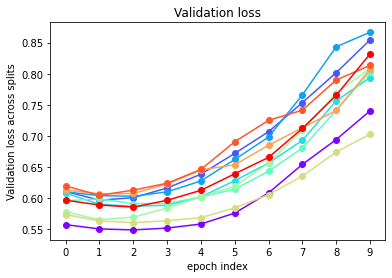

In [8]:
for y, c in zip(splits_bert.keys(), colors):
    data=splits_bert[y]['valid_loss']
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
# plt.legend()
plt.ylabel('Validation loss across splits') #set the label for y axis
plt.xlabel('epoch index') #set the label for x-axis
plt.title('Validation loss') #set the title of the graph
plt.show() #display the graph

### Check stories

In [9]:
sent_label_db = common_utils.concat_dbs(dir_name,"sent_db")

In [10]:
sent_label_db

,file_idx,sent_idx,is_question,text,sent_idx_in_block,block_idx,is_nar,doc_idx,par_db_idx,par_idx_in_doc,par_pos_in_doc,par_type,block_type,nar_idx,sent_len,is_client,sent_idx_in_par,sent_pos_in_par,sent_pos_in_doc
0,1,0,0.0,אז היום אנחנו נפגשים פה ב 123 אבל שבוע הבא בח...,0.0,0.0,0.0,1.0,0.0,0.0,0.004878,therapist,not_nar,0.0,50.0,0,0,1.000000,0.001631
1,1,1,0.0,כן,0.0,1.0,0.0,1.0,1.0,1.0,0.009756,client,not_nar,0.0,2.0,1,0,1.000000,0.003263
2,1,2,1.0,אוקיי מה שלומך,0.0,2.0,0.0,1.0,2.0,2.0,0.014634,therapist,not_nar,0.0,16.0,0,0,1.000000,0.004894
3,1,3,0.0,ברוך השם,0.0,3.0,0.0,1.0,3.0,3.0,0.019512,client,not_nar,0.0,8.0,1,0,1.000000,0.006525
4,1,4,0.0,מחר יש לכם יום טיול,0.0,4.0,0.0,1.0,4.0,4.0,0.024390,therapist,not_nar,0.0,19.0,0,0,1.000000,0.008157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38776,80,525,0.0,שאני מרגיש בהם לא נוח,3.0,230.0,0.0,80.0,222.0,222.0,0.991111,client,not_nar,0.0,21.0,1,3,0.666667,0.992453
38777,80,526,0.0,אז כאילו למה למה אני מתגעגע,4.0,230.0,0.0,80.0,222.0,222.0,0.991111,client,not_nar,0.0,27.0,1,4,0.833333,0.994340
38778,80,527,0.0,או למה אני למה אני רוצה,5.0,230.0,0.0,80.0,222.0,222.0,0.991111,client,not_nar,0.0,23.0,1,5,1.000000,0.996226
38779,80,528,1.0,והצלחת לענות לעצמך,0.0,231.0,0.0,80.0,223.0,223.0,0.995556,therapist,not_nar,0.0,19.0,0,0,1.000000,0.998113
